In [2]:
# 1) 한글 폰트 설치
!apt-get -y install fonts-nanum fonts-noto-cjk > /dev/null

# 2) 매트플롯립에 폰트 등록 및 기본 폰트 지정
import matplotlib as mpl
from matplotlib import font_manager as fm
import glob, os

# 설치된 나눔/노토 폰트 경로 자동 탐색 후 등록
font_paths = []
font_paths += glob.glob("/usr/share/fonts/truetype/nanum/*.ttf")
font_paths += glob.glob("/usr/share/fonts/opentype/noto/*CJK*.otf")
font_paths += glob.glob("/usr/share/fonts/opentype/noto/*CJK*.ttc")

for p in font_paths:
    try:
        fm.fontManager.addfont(p)
    except Exception:
        pass

# 3) 기본 폰트 패밀리 지정(우선순위)
mpl.rcParams["font.family"] = ["NanumGothic", "Noto Sans CJK KR", "AppleGothic", "Malgun Gothic", "DejaVu Sans"]
mpl.rcParams["axes.unicode_minus"] = False

# 4) 폰트 캐시 재로딩(중요)
try:
    fm._load_fontmanager(try_read_cache=False)  # Matplotlib >=3.6 권장
except Exception:
    fm._rebuild()  # 구버전 대응

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

DATE_COL_PATTERN = re.compile(r'^\s*\d{4}\.(?:0?[1-9]|1[0-2])\s*$')

def to_month_end_datetime(s):
    s = str(s).strip()
    s = re.sub(r'\s*p\)\s*$', '', s)   # ' p)' 제거
    dt = pd.to_datetime(s, format='%Y.%m', errors='coerce')
    if pd.isna(dt):
        return pd.NaT
    return pd.Period(dt, freq='M').to_timestamp(how='end')

def detect_date_columns(df):
    return [c for c in df.columns if DATE_COL_PATTERN.match(str(c))]

def melt_wide_monthly(df, id_col=None):
    date_cols = detect_date_columns(df)
    if not date_cols:
        return None
    id_vars = [id_col] if (id_col is not None and id_col in df.columns) else []
    long_df = df.melt(id_vars=id_vars, value_vars=date_cols,
                      var_name='DateStr', value_name='Value')
    long_df['Date'] = long_df['DateStr'].apply(to_month_end_datetime)
    long_df = long_df[['Date','Value']].dropna().sort_values('Date')
    return long_df

def load_series_auto(csv_path, preferred_label_col=None, preferred_label_value=None):
    last_err = None
    for enc in ['utf-8-sig','cp949','euc-kr','utf-8']:
        try:
            df = pd.read_csv(csv_path, encoding=enc)
            break
        except Exception as e:
            last_err = e
            df = None
    if df is None:
        raise RuntimeError(f"CSV 읽기 실패: {last_err}")

    if preferred_label_col and preferred_label_col in df.columns and preferred_label_value is not None:
        df = df[df[preferred_label_col].astype(str).str.strip() == str(preferred_label_value).strip()]

    long_df = melt_wide_monthly(df, id_col=preferred_label_col if (df is not None and preferred_label_col in df.columns) else None)
    if long_df is not None and not long_df.empty:
        s = pd.Series(long_df['Value'].astype(float).values, index=long_df['Date'].values)
        s = s[~s.index.duplicated(keep='last')].sort_index()
        return s

    date_candidates = [c for c in df.columns if str(c).strip() in ['Date','날짜','기간','기준월','월']]
    val_candidates  = [c for c in df.columns if str(c).strip() in ['Value','값','지수','지표값','Index','IndexValue','값(지수)']]
    if not val_candidates:
        numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if len(numeric_cols) == 1:
            val_candidates = numeric_cols

    if date_candidates and val_candidates:
        dcol, vcol = date_candidates[0], val_candidates[0]
        tmp = df[[dcol, vcol]].copy()
        tmp['Date'] = tmp[dcol].apply(lambda x: to_month_end_datetime(x) if pd.notna(x) else pd.NaT)
        tmp = tmp[['Date', vcol]].dropna().rename(columns={vcol:'Value'})
        s = pd.Series(tmp['Value'].astype(float).values, index=tmp['Date'].values)
        s = s[~s.index.duplicated(keep='last')].sort_index()
        return s

    raise ValueError(f"형식 자동 인식 실패. 열 목록: {list(df.columns)}")

def bk_cycle(series_log, low=18, high=96, K=12):
    cyc = sm.tsa.filters.bkfilter(series_log.dropna(), low=low, high=96, K=K)
    cyc.name = 'cycle'
    return cyc

def zscore_over_overlap(s1, s2):
    common_idx = s1.index.intersection(s2.index)
    a = s1.loc[common_idx]
    b = s2.loc[common_idx]
    az = (a - a.mean()) / a.std(ddof=0)
    bz = (b - b.mean()) / b.std(ddof=0)
    return az, bz

def normalize_base100_over_overlap(level1, level2):
    common_idx = level1.index.intersection(level2.index)
    a = level1.loc[common_idx].astype(float)
    b = level2.loc[common_idx].astype(float)
    a_norm = a / a.iloc[0] * 100.0
    b_norm = b / b.iloc[0] * 100.0
    return a_norm, b_norm

In [4]:
from google.colab import files
uploaded = files.upload()
list(uploaded.keys())

Saving export_price_index.csv to export_price_index.csv
Saving ip_index.csv to ip_index.csv


['export_price_index.csv', 'ip_index.csv']

In [6]:
# === 셀3E: export_price_index.csv(YYYY/MM 헤더 대응) + ip_index.csv 를 로그→BK ===
import re
import pandas as pd
import numpy as np
import statsmodels.api as sm

IP_CSV  = '/content/ip_index.csv'
EXP_CSV = '/content/export_price_index.csv'

# 1) ip_index.csv는 기존 유틸 사용 (라벨/날짜가 YYYY.MM)
ip_series = load_series_auto(IP_CSV,
                             preferred_label_col='산업별 지수',
                             preferred_label_value='전산업생산지수')

# 2) export_price_index.csv: YYYY/MM 헤더 인식해서 wide→long 변환
DATE_HEADER_RE = re.compile(r'^\s*\d{4}[./-](?:0?[1-9]|1[0-2])\s*$')

def _to_month_end_any(s: str):
    s = str(s).strip()
    s = re.sub(r'\s*p\)\s*$', '', s)
    for fmt in ('%Y.%m','%Y-%m','%Y/%m'):
        try:
            dt = pd.to_datetime(s, format=fmt)
            return pd.Period(dt, freq='M').to_timestamp(how='end')
        except Exception:
            pass
    return pd.NaT

def _read_csv_any(path):
    for enc in ('utf-8-sig','cp949','euc-kr','utf-8'):
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception:
            continue
    raise RuntimeError(f'CSV 읽기 실패: {path}')

exp_df = _read_csv_any(EXP_CSV)

# 날짜형 헤더(YYYY.MM / YYYY-MM / YYYY/MM)만 추출
date_cols = [c for c in exp_df.columns if DATE_HEADER_RE.match(str(c))]
if len(date_cols) < 3:
    raise ValueError(f'export_price_index.csv: 날짜형 열을 찾지 못함. columns[:6]={list(exp_df.columns)[:6]}')

# wide → long → Series
exp_long = exp_df.melt(value_vars=date_cols, var_name='DateStr', value_name='Value')
exp_long['Date'] = exp_long['DateStr'].apply(_to_month_end_any)
exp_series = pd.Series(pd.to_numeric(exp_long['Value'], errors='coerce').values,
                       index=exp_long['Date']).dropna()
exp_series = exp_series[~exp_series.index.duplicated(keep='last')].sort_index()

# 3) 로그 변환 + BK 필터(18~96, K=12)
ip_log   = np.log(ip_series.astype(float))
exp_log  = np.log(exp_series.astype(float))

ip_cycle  = sm.tsa.filters.bkfilter(ip_log.dropna(),  low=18, high=96, K=12)
exp_cycle = sm.tsa.filters.bkfilter(exp_log.dropna(), high=96, low=18, K=12)  # 동일 파라미터

def _span(s): return s.index.min().date(), s.index.max().date(), s.shape[0]
print("IP 범위:",  _span(ip_series))
print("EXP 범위:", _span(exp_series))
print("IP(BK)  :", _span(ip_cycle.dropna()))
print("EXP(BK) :", _span(exp_cycle.dropna()))

IP 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 4, 30), 304)
EXP 범위: (datetime.date(2000, 1, 31), datetime.date(2025, 7, 31), 307)
IP(BK)  : (datetime.date(2001, 1, 31), datetime.date(2024, 4, 30), 280)
EXP(BK) : (datetime.date(2001, 1, 31), datetime.date(2024, 7, 31), 283)


z-score 상관계수: 0.699
최고 교차상관: lag=-2개월, corr=0.773
해석: 전산업생산이 선행


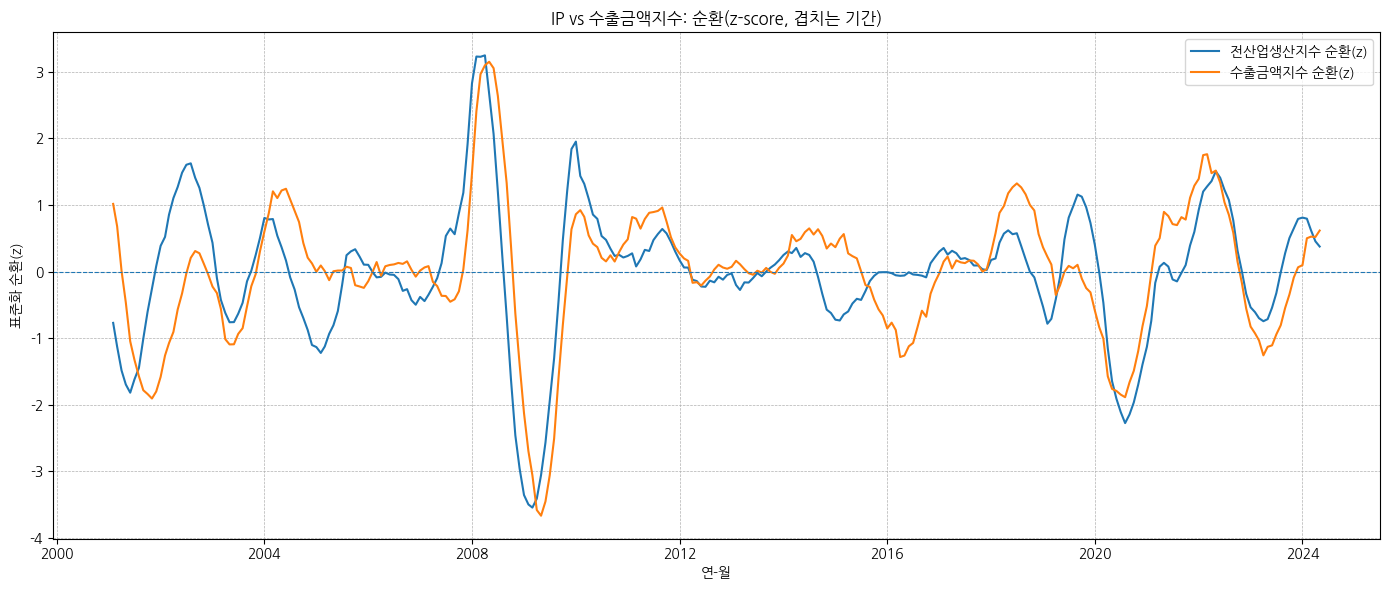

In [7]:
# 셀4에서 변수만 교체
idx = ip_cycle.dropna().index.intersection(exp_cycle.dropna().index)
ip_c   = ip_cycle.loc[idx]
exp_c  = exp_cycle.loc[idx]
ip_z   = (ip_c  - ip_c.mean())  / ip_c.std(ddof=0)
exp_z  = (exp_c - exp_c.mean()) / exp_c.std(ddof=0)

pearson_r = ip_z.corr(exp_z)
print("z-score 상관계수:", round(float(pearson_r), 3))

def best_lag(a, b, max_lag=12):
    best = (0, a.corr(b))
    for lag in range(-max_lag, max_lag+1):
        if lag == 0:
            continue
        corr = a.corr(b.shift(lag))
        if pd.notna(corr) and corr > best[1]:
            best = (lag, corr)
    return best

lag, lag_corr = best_lag(ip_z, exp_z, max_lag=12)
print(f"최고 교차상관: lag={lag}개월, corr={round(float(lag_corr),3)}")
print("해석:",
      "수출금액지수가 선행" if lag>0 else
      "전산업생산이 선행"   if lag<0 else "뚜렷한 선행·후행 없음")

plt.figure(figsize=(14,6))
plt.plot(ip_z.index,  ip_z.values,  label='전산업생산지수 순환(z)')
plt.plot(exp_z.index, exp_z.values, label='수출금액지수 순환(z)')
plt.axhline(0, linestyle='--', linewidth=0.8)
plt.title('IP vs 수출금액지수: 순환(z-score, 겹치는 기간)')
plt.xlabel('연-월'); plt.ylabel('표준화 순환(z)')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(); plt.tight_layout(); plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import numpy as np

# 공통 구간 정렬
idx = ip_cycle.dropna().index.intersection(exp_cycle.dropna().index)

# (1) exp_cycle ~ ip_cycle
y = exp_cycle.loc[idx].values
X = sm.add_constant(ip_cycle.loc[idx].values)
m1 = sm.OLS(y, X).fit()
print("[exp ← ip] R²:", round(m1.rsquared, 3),
      "RMSE:", round(float(np.sqrt(mean_squared_error(y, m1.predict(X)))), 3))

# (2) ip_cycle ~ exp_cycle (참고)
y2 = ip_cycle.loc[idx].values
X2 = sm.add_constant(exp_cycle.loc[idx].values)
m2 = sm.OLS(y2, X2).fit()
print("[ip ← exp] R²:", round(m2.rsquared, 3),
      "RMSE:", round(float(np.sqrt(mean_squared_error(y2, m2.predict(X2)))), 3))

# 상세 회귀 결과 확인하려면 아래 주석 해제
# print(m1.summary())
# print(m2.summary())

[exp ← ip] R²: 0.489 RMSE: 0.032
[ip ← exp] R²: 0.489 RMSE: 0.006
